In [1]:
from matplotlib import cm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob,os
from scipy import stats
import seaborn as sns
import pickle as pk

In [19]:
merged = []
for f in sorted(glob.glob('/Users/jz-rolling/Desktop/Rv1830_manuscript/Size_calculation/20220118/Colonies_20220121/Colonies/*/')):
    merged.append(pd.read_excel(f+'colony_profiles.xlsx'))
merged = pd.concat(merged)
merged.to_csv('/Users/jz-rolling/Desktop/Rv1830_manuscript/Size_calculation/20220118/colony_stats.csv')

In [24]:
# 
filtered = merged[(merged['Fraction_contact']<0.4)&\
                  (merged['Days']<=27)&\
                  (merged['Area']<5000)].copy()
cstats = []
area_cutoffs = [10,25,50,100]
col_names = ['Colony_id','Plate','Condition','Strain','Replicate','Column','Row',
             'Logistic_x','Logistic_y','Logistic_L','Logistic_x0','Logistic_k',
             'Logistic_rmax','Max_expansion_rate',
             'Time_to_colony_formation',
             'Time_to_colony_formation_logistic_areacutoff_10',
             'Time_to_colony_formation_logistic_areacutoff_25',
             'Time_to_colony_formation_logistic_areacutoff_50',
             'Time_to_colony_formation_logistic_areacutoff_100',
             ]
for i,c in enumerate(filtered['Colony_id'].unique()):
    subset = filtered[filtered['Colony_id']==c]
    t,a = subset['Days'].values,subset['Area'].values
    
    nonzero = (a>0)*1
    cond1 = (nonzero[1:]-nonzero[:-1]).min()>=0
    cond2 = a[-1]>=0.7*np.max(a)
    cond3 = nonzero.sum()>2
    cond4 = a.max()>200
    cond5 = ((a[1:]-a[:-1])/(1+a[:-1])).min() > -0.1
    if  cond1*cond2*cond3*cond4*cond5:
        fx,fy,L,x0,k = fit_sigmoid(t,a,plot=False)
        logistic_t0 = []
        vis_t0 = t[a>0][0]
        rmax_logistic = (np.sort((fy[1:]-fy[:-1])/fy[:-1])).max()
        nonzero_growth = a[nonzero==1]
        nonzero_time = t[nonzero==1]
        da = nonzero_growth[1:]-nonzero_growth[:-1]
        dt = nonzero_time[1:]-nonzero_time[:-1]
        norm_r = da/(dt*nonzero_growth[:-1])
        rmax_raw = np.mean(np.sort(norm_r)[-3:])
        for th in area_cutoffs:
            logistic_t0.append(fx[fy>th][0])
        colony_v = [c]+list(subset[subset.columns[-6:]].values[0])+\
                   [fx,fy,L,x0,k,rmax_logistic,rmax_raw,vis_t0]+logistic_t0
        cstats.append(colony_v)
cstats = pd.DataFrame(cstats, columns=col_names)

In [26]:
cstats_filtered = cstats[cstats['Max_expansion_rate']<2.5].copy()
nc_median = cstats_filtered[(cstats_filtered['Condition']=='No drug')&\
                            (cstats_filtered['Strain']=='N1')]['Time_to_colony_formation_logistic_areacutoff_50'].median()
cstats_filtered['delay_relative_to_NC'] = cstats_filtered['Time_to_colony_formation_logistic_areacutoff_50']-nc_median
cstats_filtered.to_excel('/Users/jz-rolling/Desktop/Rv1830_manuscript/Size_calculation/20220118/grouped_colony_stats_with_delaystats_revised.xlsx')

In [3]:
cstats_filtered = pd.read_excel('/Users/jz-rolling/Desktop/Rv1830_manuscript/Size_calculation/20220118/grouped_colony_stats_with_delaystats.xlsx')

(11.0, 22.0)

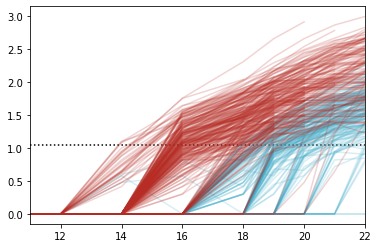

In [60]:
r8_color = tuple(np.array([183,44,36])/255)
wt_color = tuple(np.array([65,173,202])/255)
fig=plt.figure(figsize=(6,4))
for c in eth['Colony_id'].unique():
    subset = eth[eth['Colony_id']==c]
    x=subset['Days'].values
    y=np.log10(subset['Area']+5)-np.log10(5)
    strain = subset['Strain'].unique()[0]
    if x[subset['Area'].values>0][0]>10:
        if strain == 'R8':
            color = r8_color
        else:
            color = wt_color
        plt.plot(x,y,color=color,alpha=0.2)
plt.hlines(y=np.log10(55)-np.log10(5),xmin=11,xmax=22,color='black',ls=':')
plt.xlim(11,22)

In [10]:
r8_color = tuple(np.array([183,44,36])/255)
n1_color = tuple(np.array([65,173,202])/255)
for cond in cstats_filtered['Condition'].unique():
    subset = cstats[cstats['Condition']==cond]
    n1 = subset[subset['Strain']=='N1']
    r8 = subset[subset['Strain']=='R8']
    n1_x = np.vstack(n1['Logistic_x'].values)
    n1_y = np.vstack(n1['Logistic_y'].values)
    r8_x = np.vstack(r8['Logistic_x'].values)
    r8_y = np.vstack(r8['Logistic_y'].values)
    fig=plt.figure(figsize=(4,4))
    plt.title(cond,fontname='Arial',fontsize=14)
    for i in range(len(r8_x)):
        plt.plot(r8_x[i],r8_y[i],color=r8_color,alpha=0.2,ls=':',lw=1)
    for i in range(len(n1_x)):
        plt.plot(n1_x[i],n1_y[i],color=n1_color,alpha=0.2,ls=':',lw=1)
    r8_mean = np.mean(r8_y,axis=0)
    n1_mean = np.mean(n1_y,axis=0)
    r8_sem = np.std(r8_y,axis=0)/np.sqrt(len(r8_y))
    n1_sem = np.std(n1_y,axis=0)/np.sqrt(len(n1_y))
    plt.plot(n1_x[0],n1_mean,color=n1_color,lw=3,label='N1')
    plt.plot(r8_x[0],r8_mean,color=r8_color,lw=3,label='R8')
    plt.fill_between(x=r8_x[0],y1=r8_mean-r8_sem,y2=r8_mean+r8_sem,color=r8_color,alpha=0.3)
    plt.fill_between(x=n1_x[0],y1=n1_mean-n1_sem,y2=n1_mean+n1_sem,color=n1_color,alpha=0.3)
    plt.ylim(0,2000)
    plt.xlim(10,28)
    plt.ylabel('Colony area [pix.]',fontname='Arial',fontsize=14)
    plt.xlabel('Days',fontname='Arial',fontsize=14)
    plt.legend(prop={'family':'Arial','size':14})
    plt.savefig('/Users/jz-rolling/Desktop/Size_calculation/20220118/Plots/{}_growth_dynamics.png'.format(cond),dpi=160,bbox_inches='tight')
    plt.close()